In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
user = pd.read_csv("takehome_users.csv", parse_dates=['creation_time'], encoding="ISO-8859-1")

user['last_session_creation_time'] = pd.to_datetime(user.last_session_creation_time, unit='s') # convert unix timestamp to datetime

In [3]:
engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

In [4]:
user.set_index('object_id',inplace=True) # set 'object_id' as the index of 'user'
user.index.name = 'user_id' # update the name of the index to be consistent with other dataframe 'engagement'
user['adopted_user'] = 0 # initiate 'adopted_user' column to 0 (non-adopted user)


In [5]:
# doublecheck that there is no duplicated entry for the same user on the same day in the 'engagement' dataframe
copy = engagement.copy()
copy['time_stamp'] = copy.time_stamp.dt.date
assert (copy.groupby(['user_id','time_stamp']).visited.count() == 1).all()


In [6]:
# compute 'adopted user'

# first sort the dataframe by 'user_id' first, then 'time_stamp'
engagement = engagement.sort_values(['user_id','time_stamp']) 

# then loop over the 'engagement' dataframe, and check if 'user_id' is the same as the following two entries,
# if so, check if their timestamps are within a seven-day period
for idx in engagement.index[:-2]:
    if engagement.loc[idx, 'user_id'] == engagement.loc[idx+2, 'user_id']:
        if (engagement.loc[idx+2,'time_stamp'] - engagement.loc[idx,'time_stamp']).days <= 7:
            user_id = engagement.loc[idx,'user_id']
            user.loc[user_id, 'adopted_user'] = 1

In [7]:

user.adopted_user.value_counts() # count adopted users vs non-adopted users

0    10344
1     1656
Name: adopted_user, dtype: int64

In [8]:
user[user.last_session_creation_time.isnull()].adopted_user.value_counts()

0    3177
Name: adopted_user, dtype: int64

In [9]:
user['invited'] = user.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)
user.invited.value_counts()

1    6417
0    5583
Name: invited, dtype: int64

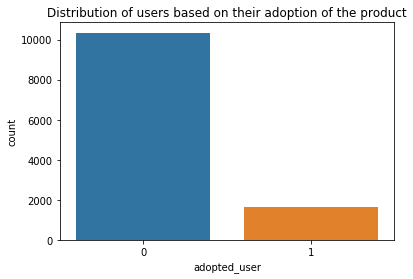

In [10]:

ax = sns.countplot(x="adopted_user", data=user)
ax.set_title('Distribution of users based on their adoption of the product');

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
opted_in_to_mailing_list,1.000000,0.483529,0.003432,0.004699,0.008838,0.006934
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.003687,0.006578,0.002216
org_id,0.003432,0.009275,1.000000,-0.057780,0.066995,-0.018442
invited_by_user_id,0.004699,0.003687,-0.057780,1.000000,0.001185,NaN
adopted_user,0.008838,0.006578,0.066995,0.001185,1.000000,0.027831
invited,0.006934,0.002216,-0.018442,NaN,0.027831,1.000000


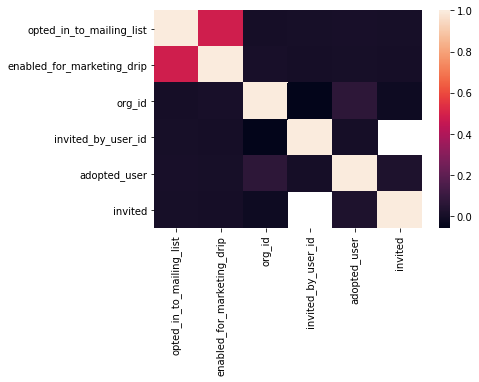

In [11]:
sns.heatmap(user.corr());
user.corr()

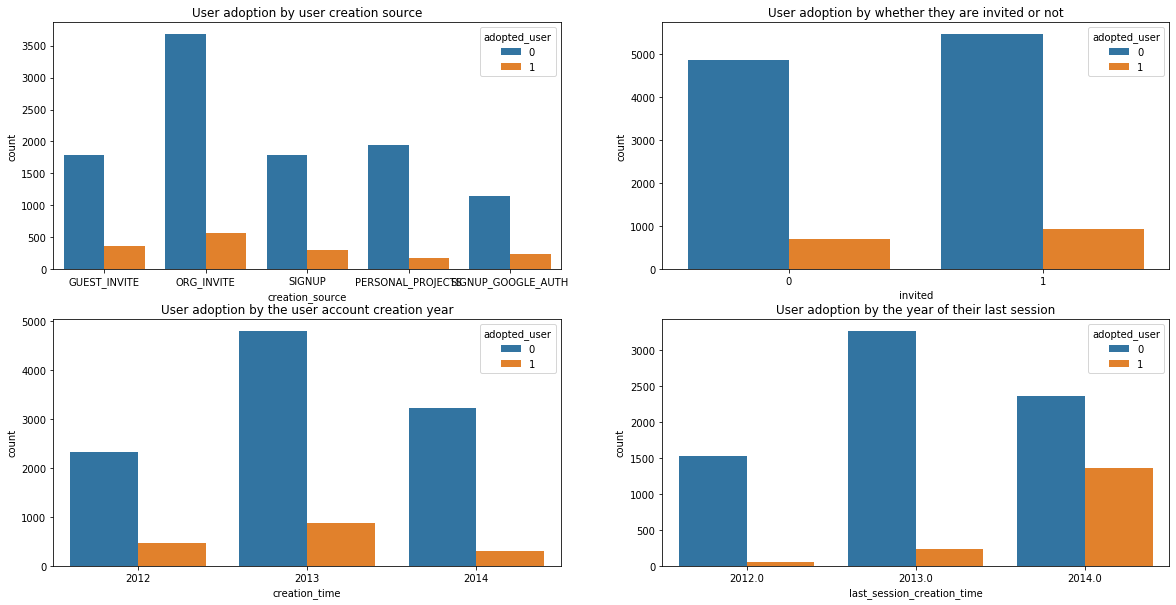

In [12]:
plt.figure(figsize=(20,10));
ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x='creation_source', hue='adopted_user', data=user, ax=ax1)
ax1.set_title('User adoption by user creation source');

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x=user.invited, hue=user.adopted_user, ax=ax2)
ax2.set_title('User adoption by whether they are invited or not');

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(x=user.creation_time.dt.year, hue=user.adopted_user, ax=ax3)
ax3.set_title('User adoption by the user account creation year');

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x=user.last_session_creation_time.dt.year, hue=user.adopted_user, ax=ax4)
ax4.set_title('User adoption by the year of their last session');